## 1. Standard Imports

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt

## 2. Create temporal Sequences

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
# number of Datapoints
N = 500
# range : [0, 30pi]
t_arr = np.linspace(start=0 ,stop=30*np.pi ,num=N)

data = torch.zeros(N)

for idx, t in enumerate(t_arr):
    
    x = np.sin(t + np.cos(t))
    #x = np.sin(t)
    x = np.round(x, 4)
    #data.append( x )
    data[idx] = torch.tensor(x)

#### Data visualization

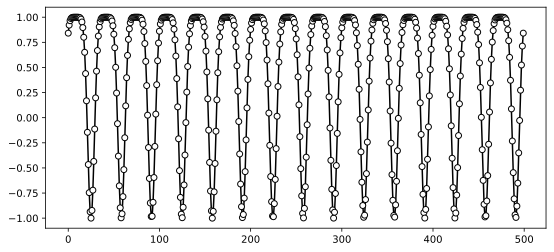

In [5]:
plt.figure(figsize=(9,4), dpi=135)

#plt.plot([-2,N+1],[0,0],'--', color=[.8,.8,.8])
plt.plot(data,'ko-',markerfacecolor='w')
#plt.xlim([-1,N+1])

plt.show()

## 3. Custom GRU class

In [6]:
class GRUnet(nn.Module):
    
    def __init__(self, inputSize, hiddenSize, numLayers=1, batchSize=1, Print=False):
        super().__init__()

        # store parameters
        self.input_size = inputSize
        self.hidden_size = hiddenSize
        self.num_layers = numLayers
        self.batch_size = batchSize
        self.print = Print

        # RNN Layer
        self.gru = nn.GRU(inputSize, hiddenSize, numLayers)

        # Linear layer for output
        self.out = nn.Linear(hiddenSize, 1)
  
    def forward(self,x):
    
        if self.print : print(f'Input: {list(x.shape)}')
    
        # initialize hidden and cell state for first input
        hiddenstate = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        #cellstate = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        if self.print: print(f'HiddenState Before: {list(hiddenstate.shape)}')
        #if self.print : print(f"Cellstate Before : {list(cellstate.shape)}")
        
        #state = (hiddenstate, cellstate)
        
        # run through the RNN layer
        y,grustate = self.gru(x,hiddenstate)
        if self.print:print(f'GRU-out: {list(y.shape)}')
        
        if self.print: print(f'hiddenstate After: {list(grustate.shape)}')
        #if self.print: print(f'LSTM cellstate After: {list(lstmstate[1].shape)}')
    
        # pass the RNN output through the linear output layer
        o = self.out(y)
        if self.print: print(f'Output: {list(o.shape)}')

        return o, grustate

In [7]:
# create an instance of the model and inspect
net = GRUnet(inputSize=9, hiddenSize=16, numLayers=1, batchSize=2, Print=True)
print(net), print(' ')

# check out all learnable parameters
for p in net.named_parameters():
    print(f'{p[0]} has size {list(p[1].shape)}')

GRUnet(
  (gru): GRU(9, 16)
  (out): Linear(in_features=16, out_features=1, bias=True)
)
 
gru.weight_ih_l0 has size [48, 9]
gru.weight_hh_l0 has size [48, 16]
gru.bias_ih_l0 has size [48]
gru.bias_hh_l0 has size [48]
out.weight has size [1, 16]
out.bias has size [1]


### Test the model with some data

In [8]:
# create some data
seqlen = 5
batchSize=2
inputSize=9

X = torch.rand(seqlen, batchSize, inputSize)
y = torch.rand(seqlen,batchSize,1)

yHat,h = net(X)

# try a loss function
lossfun = nn.MSELoss()
lossfun(yHat,y)

Input: [5, 2, 9]
HiddenState Before: [1, 2, 16]
GRU-out: [5, 2, 16]
hiddenstate After: [1, 2, 16]
Output: [5, 2, 1]


tensor(0.2717, grad_fn=<MseLossBackward0>)

## 4. Train the model

In [9]:
# Number of training epochs
numepochs = 100
input_size = 1
hidden_size = 5
num_layers = 1
batchsize = 1

# other parameters
N = len(data)
seqlength = int(( ( 2*np.pi - 0 )*(N-1)/(30*np.pi -1) ) + 1 )


# create a new instance of the model (and optimizer!)
net = GRUnet(inputSize=input_size,
             hiddenSize=hidden_size,
             numLayers=num_layers,
             batchSize=batchsize)

optimizer = torch.optim.SGD(net.parameters(),lr=.001)

lossfun = nn.MSELoss()


# initialize losses
losses = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over data segments
    seglosses = []
    
    # reset the hidden state on each epoch
    # create initial hidden states (typically initialized as zeros)
    #H = torch.zeros(num_layers,batchsize,hidden_size)
    #C = torch.zeros(num_layers,batchsize,hidden_size)

    # the input is actually a tuple of (hidden,cell)
    #hidden_state = (H,C)
    
    hidden_state = torch.zeros(num_layers, batchsize, hidden_size) 

    for timei in range(N-seqlength):

        # grab a snippet of data
        X = data[timei:timei+seqlength].view(seqlength, 1, 1)
        # Will take 9 sequences to predict the 10th sequence
        y_actual = data[timei+seqlength].view(1,1)

        # forward pass and loss
        yHat,hidden_state = net(X)
        
        finalValue = yHat[-1]
        loss = lossfun(finalValue,y_actual) # compare final value of output

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this segment
        seglosses.append(loss.item())

  
    # average losses from this epoch
    losses[epochi] = np.mean(seglosses)
    

    msg = f'Finished epoch {epochi+1}/{numepochs}'
    sys.stdout.write('\r' + msg)

Finished epoch 100/100

In [10]:
losses

array([0.30028287, 0.16781236, 0.1134628 , 0.09260502, 0.08366373,
       0.07851918, 0.07462491, 0.07122383, 0.06807534, 0.06508693,
       0.06221242, 0.05942313, 0.05669914, 0.05402631, 0.05139502,
       0.04879955, 0.0462379 , 0.04371126, 0.0412238 , 0.03878233,
       0.03639577, 0.03407451, 0.03182993, 0.02967369, 0.02761694,
       0.02566971, 0.0238405 , 0.02213562, 0.02055893, 0.01911194,
       0.01779353, 0.01660036, 0.015527  , 0.01456644, 0.01371047,
       0.01295008, 0.01227581, 0.01167828, 0.01114831, 0.01067723,
       0.01025705, 0.00988053, 0.00954117, 0.00923329, 0.00895199,
       0.00869308, 0.00845301, 0.0082288 , 0.00801798, 0.00781852,
       0.00762873, 0.00744725, 0.007273  , 0.00710508, 0.00694276,
       0.00678548, 0.00663278, 0.00648429, 0.0063397 , 0.00619879,
       0.00606136, 0.00592725, 0.00579634, 0.00566852, 0.00554369,
       0.00542179, 0.00530275, 0.00518649, 0.00507298, 0.00496217,
       0.004854  , 0.00474843, 0.00464543, 0.00454495, 0.00444

## Results Visualization

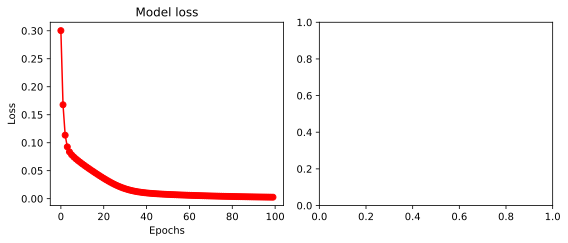

In [11]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5), dpi=135)

ax[0].plot(losses,'ro-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

# ax[1].plot(signaccuracy,'bo-',markerfacecolor='g',)
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Accuracy')
# ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.tight_layout()
plt.show()

## 5. Test the trained model 

### (i) Data generated from same function as trained data

In [12]:
# number of Datapoints
N_test = 200
# range : [0, 10pi]
t_arr = np.linspace(start=0 ,stop=10*np.pi ,num=N_test)

data_test = torch.zeros(N_test)

for idx, t in enumerate(t_arr):
    
    x = np.sin(t + np.cos(t))
    #x = np.sin(t)
    x = np.round(x, 4)
    #data.append( x )
    data_test[idx] = torch.tensor(x)

In [13]:
yHat = np.zeros(N_test)

for timei in range(N_test-seqlength):

    # grab a snippet of data
    X = data_test[timei:timei+seqlength].view(seqlength,1,1)

    # forward pass and loss
    ypred,hh = net(X)
    
    yHat[timei+seqlength] = ypred[-1]
    

### Results Visualization

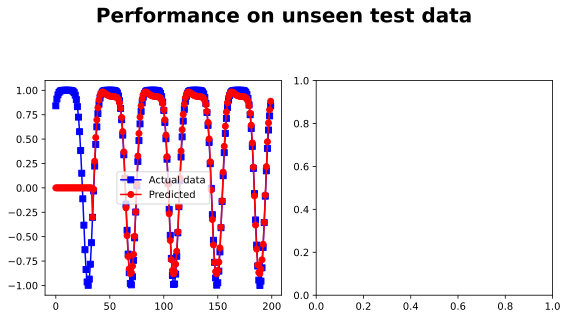

In [14]:
fig,ax = plt.subplots(1,2,figsize=(8,4), dpi=135)

ax[0].plot(data_test,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
#ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

# ax[1].plot(newdata-yHat,'k^')
# ax[1].set_ylim([-1.1,1.1])
# ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20, y=1.1)
plt.tight_layout()

plt.show()

### (ii) Data generated from different function

In [15]:
# number of Datapoints
N_test = 200
# range : [0, 10pi]
t_arr = np.linspace(start=0 ,stop=10*np.pi ,num=N_test)

data_test2 = torch.zeros(N_test)

for idx, t in enumerate(t_arr):
    
    x = np.sin(t + np.sin(t))
    #x = np.sin(t)
    x = np.round(x, 4)
    #data.append( x )
    data_test2[idx] = torch.tensor(x)

In [16]:
yHat2 = np.zeros(N_test)

for timei in range(N_test-seqlength):

    # grab a snippet of data
    X = data_test2[timei:timei+seqlength].view(seqlength,1,1)

    # forward pass 
    ypred,hh = net(X)
    
    yHat2[timei+seqlength] = ypred[-1]
    

### Results Visualization

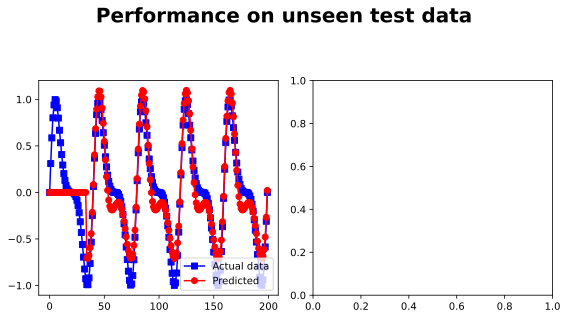

In [17]:
fig,ax = plt.subplots(1,2,figsize=(8,4), dpi=135)

ax[0].plot(data_test2,'bs-',label='Actual data')
ax[0].plot(yHat2,'ro-',label='Predicted')
#ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

# ax[1].plot(newdata-yHat,'k^')
# ax[1].set_ylim([-1.1,1.1])
# ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20, y=1.1)
plt.tight_layout()

plt.show()

## testing 

In [18]:
data[:seqlength]

tensor([ 0.8415,  0.9212,  0.9655,  0.9872,  0.9962,  0.9992,  0.9999,  1.0000,
         1.0000,  1.0000,  1.0000,  0.9998,  0.9985,  0.9939,  0.9811,  0.9525,
         0.8968,  0.8006,  0.6509,  0.4392,  0.1679, -0.1455, -0.4661, -0.7463,
        -0.9366, -0.9998, -0.9229, -0.7215, -0.4350, -0.1131,  0.1973,  0.4632,
         0.6686,  0.8125])

In [19]:
len(data)

500

In [20]:
n_iter = 700
yHat3 = np.zeros(n_iter)

data_initial = data[:seqlength]

arr = np.array([])

for timei in range(n_iter-seqlength):
    
    # grab a snippet of data
    X = data_initial[timei:timei+seqlength].view(seqlength,1,1)
    
    # forward pass 
    ypred,hh = net(X)
    
    yHat3[timei+seqlength] = ypred[-1]
    
    y_pred_np = ypred[-1].detach().numpy()
    data_initial = np.array(data_initial)
    
    data_initial = np.append(data_initial,y_pred_np )
    
    data_initial = torch.tensor(data_initial)
    
    msg = f'Finished epoch {timei+1}/{n_iter-seqlength}'
    sys.stdout.write('\r' + msg)

Finished epoch 666/666

### Results Visualization

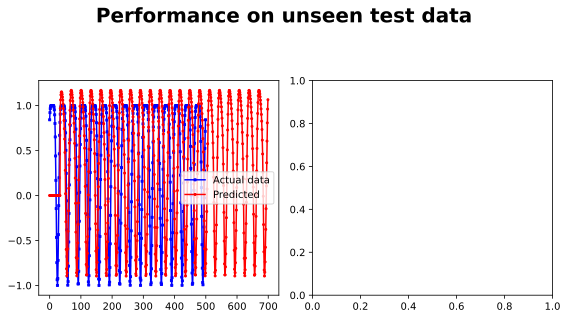

In [21]:
fig,ax = plt.subplots(1,2,figsize=(8,4), dpi=135)

ax[0].plot(data,'bs-',label='Actual data', markersize=2)
ax[0].plot(yHat3,'ro-',label='Predicted', markersize=2)
#ax[0].set_xlim([0,100])
ax[0].legend()

# ax[1].plot(newdata-yHat,'k^')
# ax[1].set_ylim([-1.1,1.1])
# ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20, y=1.1)
plt.tight_layout()

plt.show()

- Sometimes we can observe the decaying pattern in the prediction.